# Stroke Prediction 

In [98]:

import pandas as pd

import helper

# Introduction

This project focuses on predicting the likelihood of a stroke using various machine-learning models. Stroke is a significant cause of mortality globally, and early prediction can substantially enhance patient prognosis and survival rates.

The [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) used in this project contains information about individuals, including age, gender, body mass index (BMI), average glucose level, smoking status, and other health-related factors. These features are utilized to train machine learning models to predict an individual's stroke probability.

The project unfolds through several stages, including data cleaning, exploratory data analysis (EDA), hypothesis testing, and machine learning model training. The models used in this project encompass XGBoost, Random Forest, CatBoost, and LightGBM. Their performance is evaluated based on their recall, precision, and F1 score.

A significant challenge in this project was the severe imbalance in the target variable. To address this, we tuned the scale_pos_weight parameter during the hyperparameter tuning stage to optimize the performance of the LightGBM model, which initially showed the best performance.

Model performance evaluation also involved using confusion matrices and ROC curves. These tools offer a comprehensive view of the model's classification capabilities and aid in identifying the optimal classification threshold.

Lastly, we employed SHAP (Shapley Additive explanations) values to gain insights into each feature's contribution to the model's predictions, thereby understanding its significance in predicting stroke likelihood.

The entire initiative is executed in Python, utilizing the capabilities of libraries such as pandas for data manipulation, matplotlib and seaborn for data visualization, scikit-learn for machine learning, and SHAP for model interpretation.

# Review of the data

First of all, we will load the dataset and take a look at the first few rows to understand the data better.

In [99]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [100]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Shape of the dataset.

In [101]:
stroke.shape

(5110, 12)

- Checking the data types of the columns.

In [102]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


We will change the data type of 'hypertension', 'heart_disease', 'stroke' columns to 'object' as they are categorical columns.

In [103]:
for column in ['hypertension', 'heart_disease']:
    stroke[column] = stroke[column].astype('object').replace({1: 'Yes', 0: 'No'})

In [104]:
stroke[['hypertension', 'heart_disease', 'stroke']] = stroke[['hypertension', 'heart_disease', 'stroke']].astype(
    'object')

In [105]:
num_cols = stroke.select_dtypes(include=['int64', 'float64']).shape[1]

cat_cols = stroke.select_dtypes(include=['object']).shape[1]

print(f"The dataset has {num_cols} numerical columns and {cat_cols} categorical columns.")

The dataset has 4 numerical columns and 8 categorical columns.


The Stroke dataset is relatively small with 5110 rows and 12 columns. The dataset contains 7 numerical columns and 5 categorical columns. Target variable is 'stroke' column and 10 features are given to predict the target variable.

# Data Cleaning

Now, we will check for missing values , duplicates and outliers in the dataset.

- Null values

In [106]:
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- Duplicates

In [107]:
stroke.duplicated().sum()

0

- Outliers

In [108]:
helper.detect_outliers_percentile(stroke, cols_to_check=['age', 'bmi', 'avg_glucose_level'], lower_percentile=1,
                                  upper_percentile=99)

Number of outliers in age: 48
Sample size for age: 5110
Number of outliers in bmi: 0
Sample size for bmi: 4909
Number of outliers in avg_glucose_level: 104
Sample size for avg_glucose_level: 5110


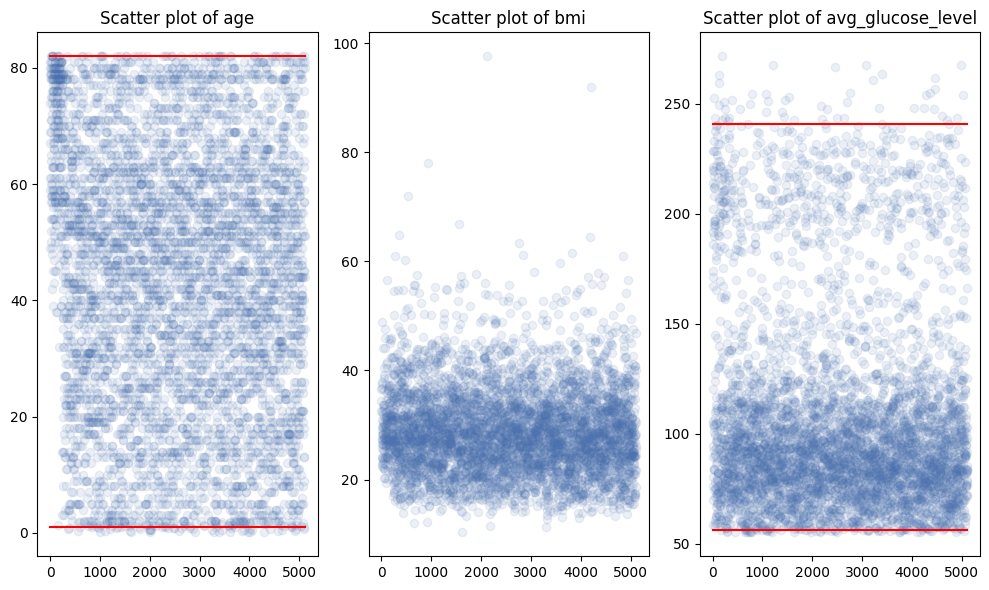

In [109]:
helper.plot_outliers(stroke, cols_to_check=['age', 'bmi', 'avg_glucose_level'], lower_percentile=1, upper_percentile=99)

In our dataset, we've found that the 'bmi' column contains missing values. We've verified that the dataset does not include duplicate entries. Additionally, we've discovered outliers in the 'bmi' and 'avg_glucose_level' columns. We won't eliminate rows with missing values or replace NaN values until we understand the 'bmi' value distribution more deeply. We will also retain the outliers initially and assess the performance of our models with these outliers present.

# Exploratory Data Analysis

## Summary statistics

In [110]:
stroke[['age', 'bmi', 'avg_glucose_level']].describe()

,age,bmi,avg_glucose_level
count,5110.000000,4909.000000,5110.000000
mean,43.226614,28.893237,106.147677
std,22.612647,7.854067,45.283560
min,0.080000,10.300000,55.120000
25%,25.000000,23.500000,77.245000
50%,45.000000,28.100000,91.885000
75%,61.000000,33.100000,114.090000
max,82.000000,97.600000,271.740000


## Data visualization

## Features Distribution

In [111]:
columns = [col for col in stroke.columns if col != 'id']

plot_types = ['count' if stroke[col].dtype == 'object' else 'hist' for col in columns]

plot_specs = list(zip(columns, plot_types))

We will remove row where gender is other as it is only one row.

In [112]:
stroke = stroke[stroke['gender'] != 'Other']

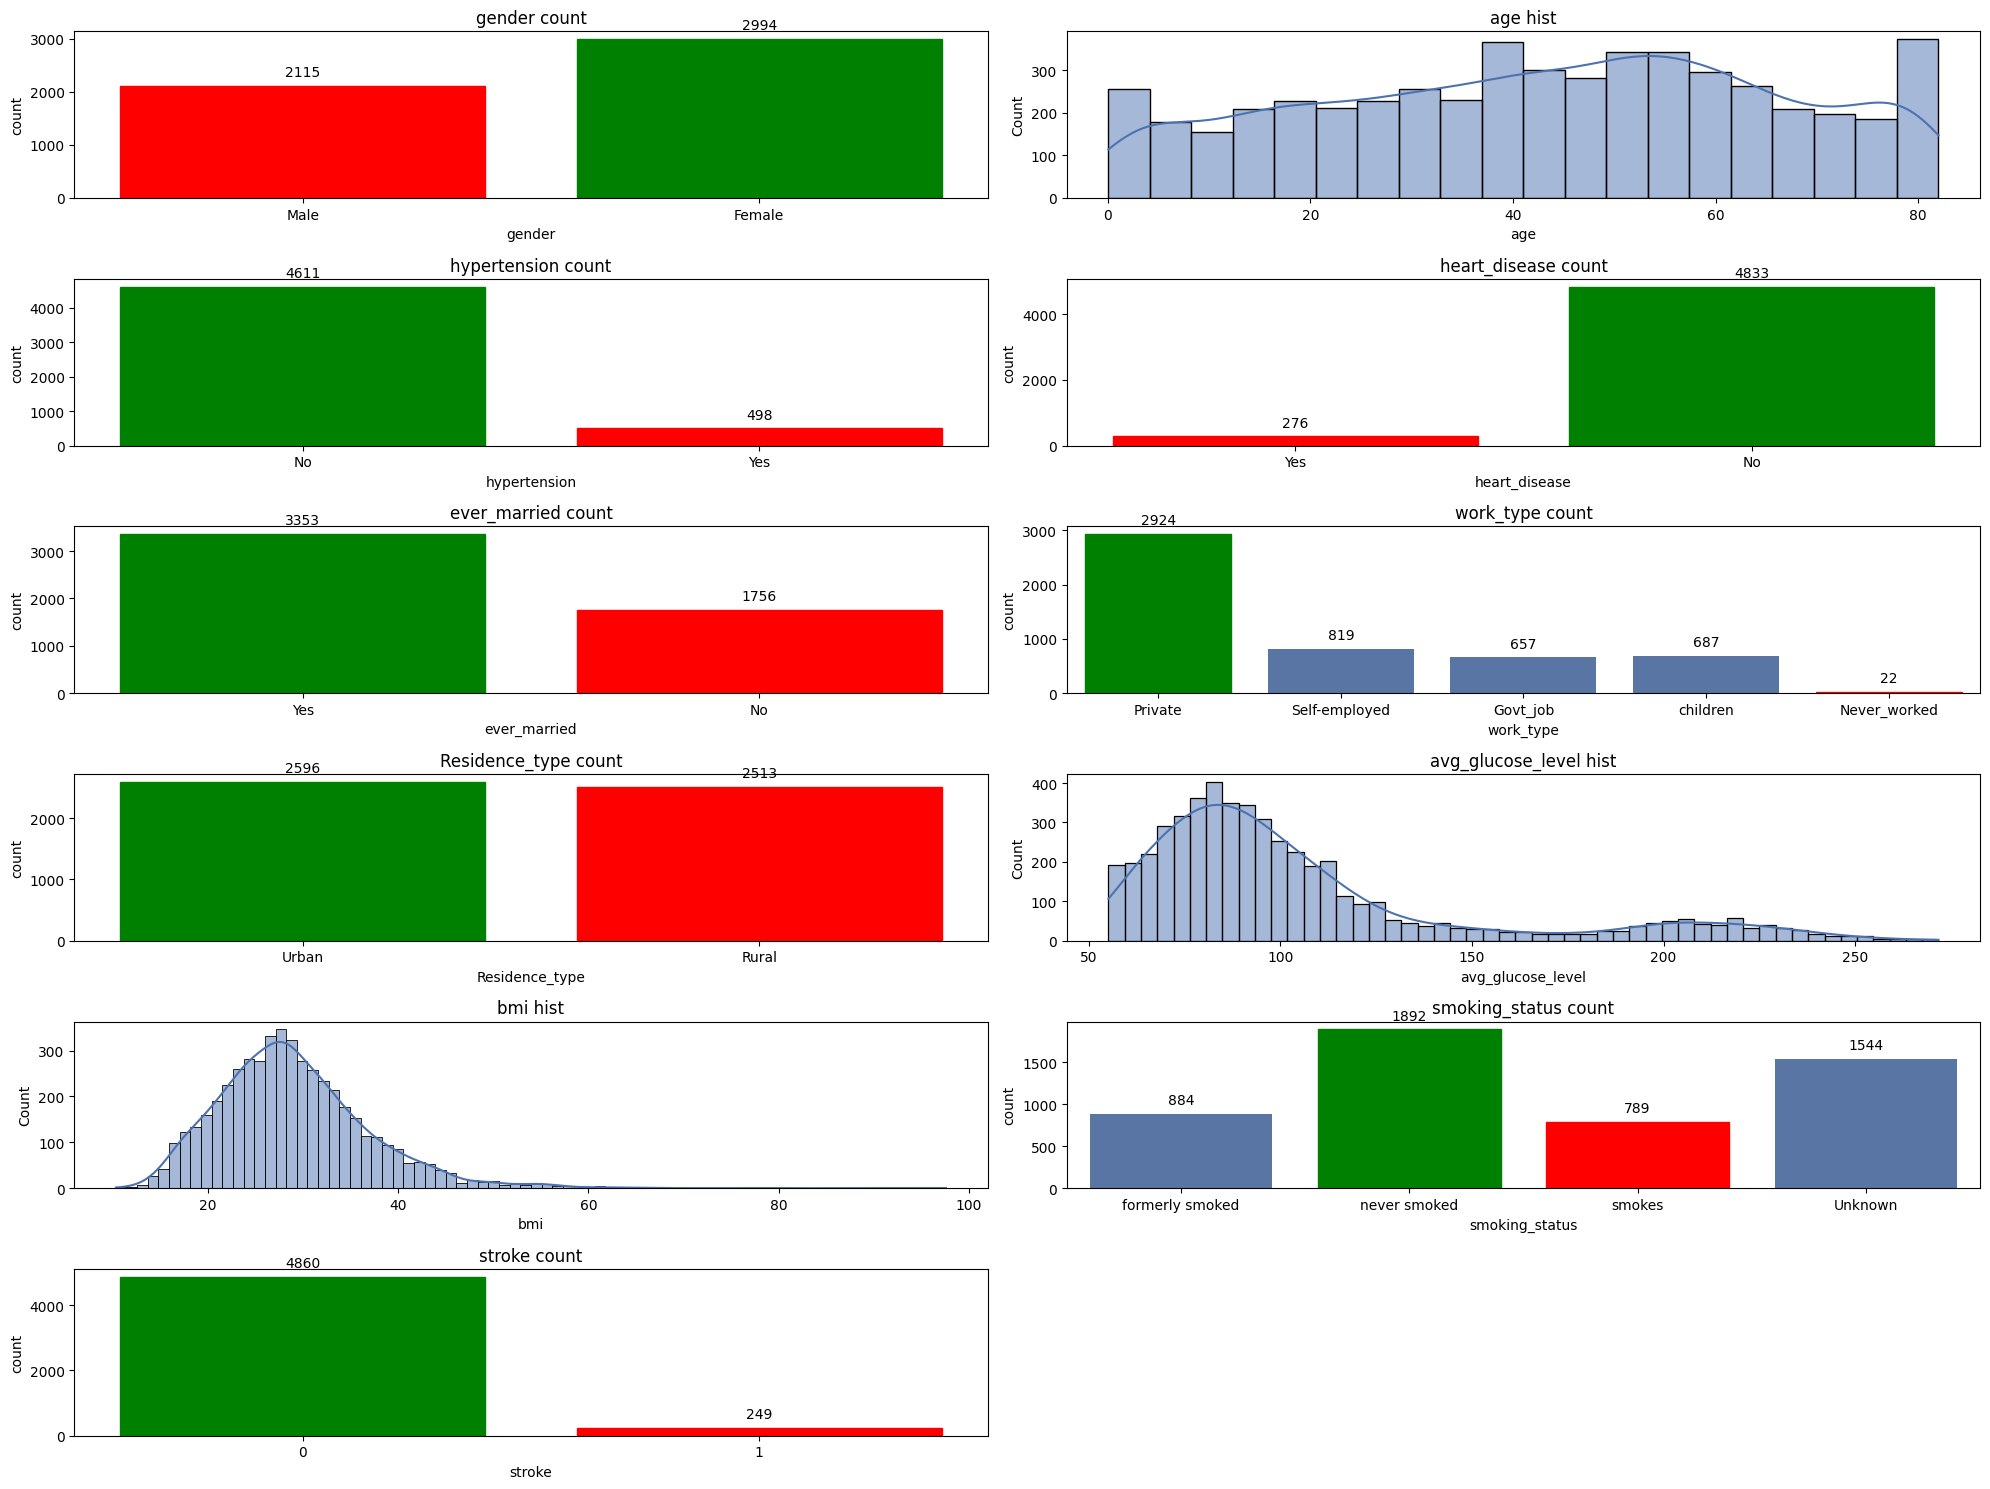

In [113]:
helper.plot_data(stroke, plot_specs)

Based on the information from [Healthline](https://www.healthline.com/health/age-range-for-stroke#stroke-risk-by-age-range), stroke risk factors and probabilities differ across age groups. Let's analyze the distribution of strokes across different ages and other features.

In [114]:
numeric_features = stroke.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = stroke.select_dtypes(include=['object']).columns.tolist()

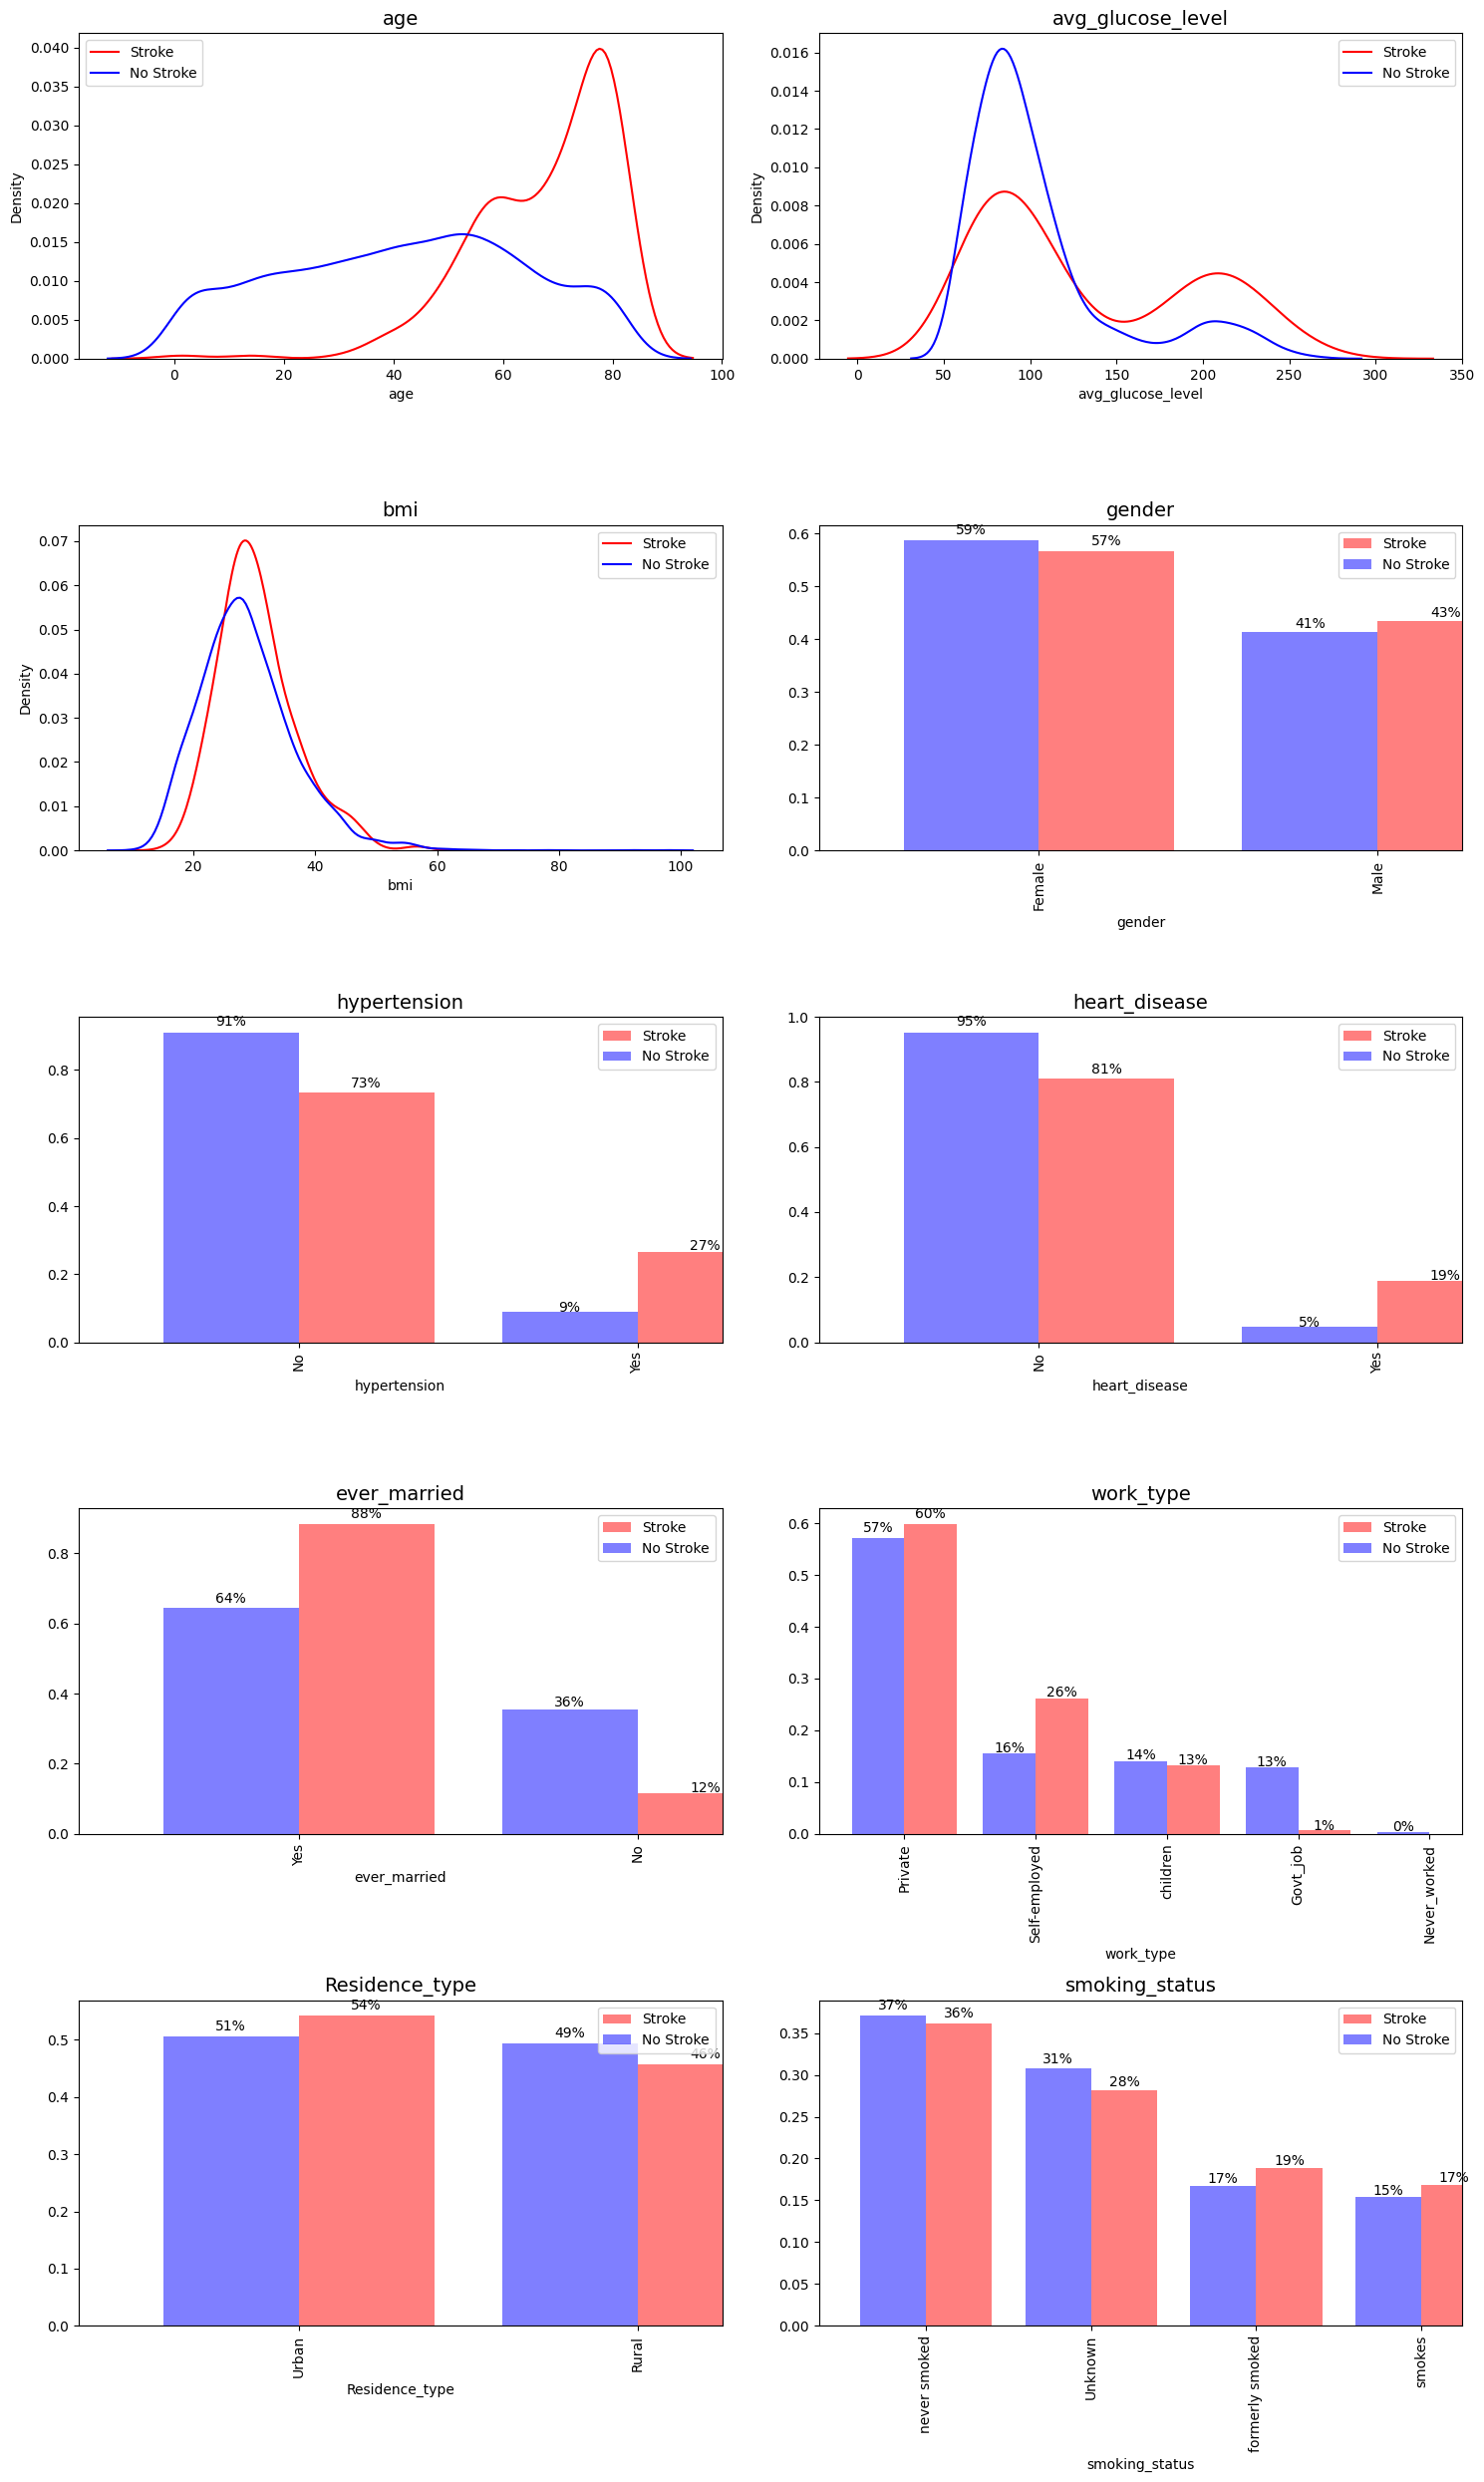

In [115]:
helper.plot_features(stroke, numeric_features, categorical_features, exclude_columns=['id', 'stroke'])

The data visualizations reveal several key insights about the dataset:

1. **Imbalance in Target Variable**: The target variable 'stroke' is highly imbalanced with 249 instances of '1' (indicating stroke) and 4861 instances of '0' (indicating no stroke). This imbalance could affect the performance of a machine-learning model and may need to be addressed during model training.

2. **BMI Distribution**: The 'bmi' feature, excluding outliers, appears normally distributed. This suggests that missing values in the 'bmi' column could be imputed using the mean of the column without significantly affecting the distribution.

3. **Relevance of Features**: The dataset includes features such as smoking status, marital status, and work type that are primarily relevant to adults. This suggests that the dataset is better suited for modeling stroke risk in adults.

4. **Age Distribution and its Implications**: The 'age' feature spans a wide range from 0 to 80s. However, it's crucial to note that the data pertaining to younger age groups may not significantly contribute to the model. This is due to the adult-centric nature of the features, which are more relevant to the risk factors for stroke in adults. Therefore, it's essential to address this potential imbalance to ensure the model's accuracy.

5. **Age and Stroke Risk**: The distribution of strokes across different ages reveals that the risk of stroke increases with age. This observation aligns with the established medical understanding that the risk of stroke escalates with age.

## Correlation 

Our dataset comprises both numerical and categorical data. We will use the Phi-K correlation coefficient to measure the correlation between the features and the target variable. The Phi-K correlation is a robust, entropy-based correlation ratio that works with categorical and numerical variables. It is an extension of the Pearson correlation coefficient, which only works with numerical variables.

The Phi-K correlation coefficient ranges from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 is a perfect negative correlation, and 0 suggests no correlation. In simpler terms, positive values mean that as one variable increases, the other variable tends to increase, while negative values mean that as one variable increases, the other variable tends to decrease.

interval columns not set, guessing: ['age', 'avg_glucose_level', 'bmi']


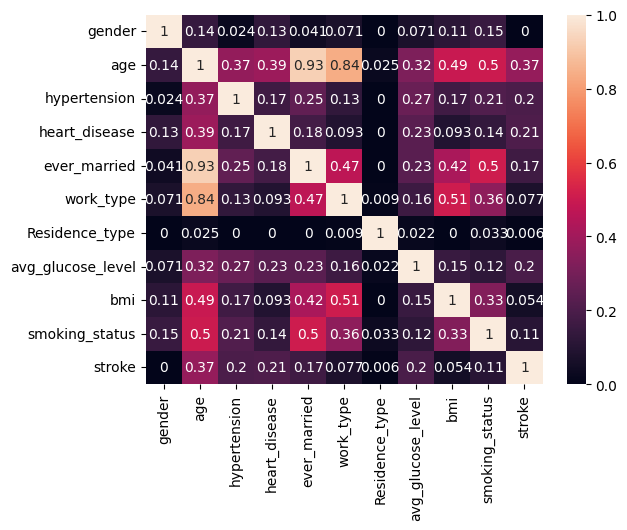

In [116]:
helper.plot_phik(stroke, 'id')

The Phi-K correlation plot offers significant insights into how the features relate to the 'stroke' target variable. Notably, there's a moderate positive correlation between the 'age' feature and the target variable, suggesting an increased stroke risk with advancing age. This observation is consistent with the established medical understanding that the risk of stroke escalates with age.

### Summary of the EDA

During the Exploratory Data Analysis (EDA) phase, we delved into the Stroke dataset, which comprises both numerical and categorical data. A crucial observation was the highly imbalanced nature of the target variable 'stroke'. This imbalance, if not addressed, could potentially impact the performance of our machine learning models, underscoring the importance of this issue in our data analysis process. 

We also found missing values in the 'bmi' column and outliers in the 'bmi' and 'avg_glucose_level' columns. However, we decided to retain these for the initial model training and assess their impact on the model's performance.

After analyzing the data, we observed that the 'age' attribute covers a broad spectrum, ranging from 0.08 to 82. This attribute is particularly significant in predicting strokes. However, considering that the dataset's features, including smoking status, marital status, and work type, are predominantly applicable to adults, we deduced that this dataset is more appropriate for modeling stroke risk in the adult population.

Further, we found that the causes of stroke vary significantly between adults and children. For children aged between 28 days and 18 years, the risk factors include sickle cell diseases, blood clotting disorders, heart and blood vessel problems, and hemorrhagic strokes. On the other hand, for adults, the risk factors are different and are more aligned with the features present in our dataset.

Finally, we used the Phi-K correlation coefficient to measure the correlation between features and target variables. We found a moderate positive correlation between the 'age' feature and the target variable, aligning with the established medical understanding that the risk of stroke escalates with age.

# Hypothesis Testing

- Null Hypothesis (H0): The 'work_type' and 'stroke' are independent, i.e., the work type of an individual does not affect the likelihood of having a stroke.
- Alternative Hypothesis (H1): The 'work_type' and 'stroke' are dependent, i.e., the work type of an individual does affect the likelihood of having a stroke.

The Chi-Square test, a statistical method we will employ, is particularly suited for this hypothesis testing due to its relevance to our variables of interest, 'work_type' and 'stroke'. This test is designed to determine if a significant association exists between two categorical variables in a sample, which aligns perfectly with our research focus. Furthermore, the Chi-Square test assumes that the observations are independent of each other, a condition that is typically met in a dataset where each row represents a different individual. 

The Chi-Square test, known for its accuracy with large sample sizes, is an ideal choice for our dataset, which contains approximately 5000 entries. This test is non-parametric, meaning it does not assume a specific distribution for the variables. This flexibility makes it a versatile tool for hypothesis testing, adapting well to various research scenarios. 

The Chi-Square test is a test of association that can determine if there is a significant association between two categorical variables. In this case, we are interested in understanding if there is an association between 'work_type' and 'stroke'. 

The results of the Chi-Square test will provide us with the following values:

- **Degrees of Freedom**: This value reflects the number of values in the final calculation of a statistic that are free to vary. In the context of a Chi-Square test, it is calculated as (number of rows - 1) * (number of columns - 1) in a contingency table.

- **Critical Value**: This point on the test distribution is compared to the test statistic to determine whether to reject the null hypothesis. The null hypothesis would be rejected if the Chi-Square statistic is greater than the critical value.

- **Chi-Square Statistic**: This is a single number that tells us how much difference exists between our observed counts and the counts we would expect if there were no relationship at all in the population. A more significant Chi-Square statistic corresponds to a tremendous difference between observed and expected counts.

- **P-value**: This is the probability of obtaining the observed data (or more extreme data) if the null hypothesis is true. It's a powerful tool in our statistical arsenal, as a smaller p-value indicates stronger evidence against the null hypothesis. If the p-value is less than 0.05, we reject the null hypothesis.

These results will help us understand the relationship between the variables we are testing and determine whether the observed differences are statistically significant.

In [117]:
helper.perform_chi2_test(stroke, 'work_type', 'stroke')

Degrees of Freedom: 4
Critical Value: 9.488
Chi-Square Statistic: 49.159
P-value: 0.0


The Chi-Square test results indicate a statistically significant association between the 'work_type' and 'stroke' variables. The p-value of 0.0000 is less than the significance level of 0.05, leading us to reject the null hypothesis. This result suggests that the work type of an individual does affect the likelihood of having a stroke.

The data visualization indicates that individuals who are self-employed have a higher risk of experiencing a stroke.